In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import cv2
import os

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torch.nn.parallel

from effdet import create_model, create_evaluator, create_dataset, create_loader
from effdet.data import resolve_input_config
from timm.utils import AverageMeter, setup_default_logging
from timm.models.layers import set_layer_config


from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

import wandb

In [16]:
import torch
import os
from datetime import datetime
import time
import random

from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [17]:
class CustomDataset(Dataset):
    '''
      data_dir: data가 존재하는 폴더 경로
      transforms: data transform (resize, crop, Totensor, etc,,,)
    '''

    def __init__(self, annotation, data_dir, transforms=None):
        super().__init__()
        self.data_dir = data_dir
        # coco annotation 불러오기 (coco API)
        self.coco = COCO(annotation)
        self.predictions = {
            "images": self.coco.dataset["images"].copy(),
            "categories": self.coco.dataset["categories"].copy(),
            "annotations": None
        }
        self.transforms = transforms

    def __getitem__(self, index: int):
        
        image_id = self.coco.getImgIds(imgIds=index)

        image_info = self.coco.loadImgs(image_id)[0]
        
        image = cv2.imread(os.path.join(self.data_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        boxes = np.array([x['bbox'] for x in anns])

        # boxex (x_min, y_min, x_max, y_max)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        labels = np.array([x['category_id'] for x in anns])
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        areas = np.array([x['area'] for x in anns])
        areas = torch.as_tensor(areas, dtype=torch.float32)
                                
        is_crowds = np.array([x['iscrowd'] for x in anns])
        is_crowds = torch.as_tensor(is_crowds, dtype=torch.int64)
                                
        segmentation = np.array([x['segmentation'] for x in anns], dtype=object)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([index]), 'area': areas,
                  'iscrowd': is_crowds}

        # transform
        if self.transforms:
            sample = self.transforms(**{
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            })
            if len(sample['bboxes']) > 0:
                image = sample['image']
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)
                target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]
                target['labels'] = torch.tensor(sample['labels'])
                

        return image, target, image_id
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds())

In [18]:
def get_train_transform():
    return A.Compose([
        A.Resize(512,512),
        A.Flip(p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields':['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields':['labels']})

In [19]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self,value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

def collate_fn(batch):
    return tuple(zip(*batch))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


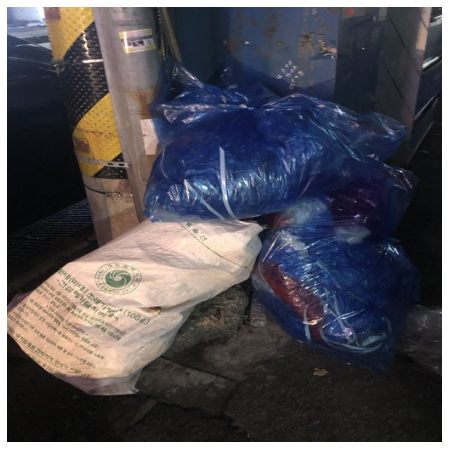

In [20]:
annotation = '/opt/ml/input/data/test.json'
data_dir = '/opt/ml/input/data/'
test_dataset = CustomDataset(annotation, data_dir, get_valid_transform())


image, target, image_id = test_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    
ax.set_axis_off()
ax.imshow(numpy_image)

In [21]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.pth')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.pth')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.pth'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def test(self, test_loader, path, threshold):
        self.load(path)
        outputs = []
        self.model.eval()

        for images, targets, image_ids in tqdm(test_loader):

            with torch.no_grad():
                
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                target = { 'bbox': boxes, 'cls': labels, 'img_scale': None, 'img_size': None }

                output = self.model(images,target)

                for out in output:
                    temp = []
                    for x_min, y_min, x_max, y_max, score, label in out:
                        if float(score) > threshold:
                            temp.append([int(label), float(score),
                                         float(x_min), float(y_min), float(x_max), float(y_max)])
                    outputs.append(temp)

        return outputs
    
    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()

                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                target = { 'bbox': boxes, 'cls': labels, 'img_scale': None, 'img_size': None }

                # loss, _, _ = self.model(images, boxes, labels)
                outputs = self.model(images,target)
                loss = outputs['loss']
                summary_loss.update(loss.detach().item(), batch_size)
                # for out in output:
                #     outputs.append({'boxes': out['boxes'].tolist(), 'scores': out['scores'].tolist(), 'labels': out['labels'].tolist()})


        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            

            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            target = { 'bbox': boxes, 'cls': labels, 'img_scale': None, 'img_size': None }

            self.optimizer.zero_grad()

            # targets
            outputs = self.model(images, target)
            loss = outputs['loss']

            loss.backward()
            # boxes = [target['boxes'].to(self.device).float() for target in targets]
            # labels = [target['labels'].to(self.device).float() for target in targets]

            # self.optimizer.zero_grad()
            
            # loss, _, _ = self.model(images, boxes, labels)
            
            # loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')


In [22]:
class TestGlobalConfig:
    num_workers = 2
    batch_size = 4
    n_epochs = 3 # n_epochs = 40
    lr = 0.0002

    folder = './work_dirs/effdet4'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------


In [23]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_testing():
    device = torch.device('cuda:0')
    net.to(device)
    path = '/opt/ml/code/mmdetection_trash/work_dirs/effdet4/best-checkpoint-039epoch.pth'
    annotation = '/opt/ml/input/data/test.json'

    test_loader = torch.utils.data.DataLoader(
        test_dataset, 
        batch_size=TestGlobalConfig.batch_size,
        num_workers=TestGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(test_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TestGlobalConfig)
    outputs = fitter.test(test_loader, path, threshold=0.1)
    return outputs



In [24]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchPredict
from effdet.efficientdet import HeadNet

def get_net():

    config = get_efficientdet_config('efficientdet_d3')

    config.image_size = [512,512]
    config.norm_kwargs=dict(eps=.001, momentum=.01)
    print(config)
#      fpn_channels=384,
#         fpn_cell_repeats=8,
#         box_class_repeats=5,
#         anchor_scale=4.0,
#         max_level=8,
#         fpn_name='bifpn_sum',  # Use unweighted sum for training stability.
#         backbone_args=dict(drop_path_rate=0.2),
    net = EfficientDet(config, pretrained_backbone=False)
    # checkpoint = torch.load('./work_dirs/effdet')
    # net.load_state_dict(checkpoint)

    net.reset_head(num_classes=11)
    net.class_net = HeadNet(config, num_outputs=config.num_classes)

    return DetBenchPredict(net)
    # return Det

net = get_net()

{'name': 'efficientdet_d3', 'backbone_name': 'efficientnet_b3', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 90, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': '', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 4, 'fpn_cell_repeats': 6, 'fpn_channels': 160, 'separable_conv': True, 'apply_resample_bn': True, 'conv_after_downsample': False, 'conv_bn_relu_pattern': False, 'use_native_resize_op': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': False, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detecti

In [25]:
outputs = run_testing()

Fitter prepared. Device is cuda:0


100%|██████████| 210/210 [00:34<00:00,  6.15it/s]


In [26]:
len(outputs)

837

In [27]:
outputs[0][1]

[2,
 0.16097143292427063,
 113.9272689819336,
 32.70609664916992,
 319.52642822265625,
 143.2794647216797]

In [28]:
for i, output in enumerate(outputs):
    for num in output:
        print(num)
        break
    break

[8, 0.7302310466766357, 179.05520629882812, 233.6739501953125, 487.9493713378906, 463.9840087890625]


In [29]:
annotation = '/opt/ml/input/data/test.json'
prediction_strings = []
file_names = []
coco = COCO(annotation)

for i, output in enumerate(outputs):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    for arr in output:
        for num in arr:
            prediction_string += str(num) + " "
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])
submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(f'effdet-d3_sn_39.csv', index=None)
print(submission.head())

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
                                    PredictionString              image_id
0  8 0.7302310466766357 179.05520629882812 233.67...  batch_01_vt/0021.jpg
1  8 0.7944927215576172 284.46856689453125 242.62...  batch_01_vt/0028.jpg
2  8 0.37049275636672974 67.70672607421875 184.89...  batch_01_vt/0031.jpg
3  8 0.8787867426872253 170.9959716796875 130.849...  batch_01_vt/0032.jpg
4  8 0.8646359443664551 40.45928192138672 68.1088...  batch_01_vt/0070.jpg
